In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('reviews_clear.csv', sep='^')
df.head()

,rt,review
0,plus,Everything was great. I was really happy stayi...
1,minus,I'm interested to see what the construction in...
2,plus,Location was good. Really good air conditioning.
3,minus,Room wasn’t clean. I found hair in the bed and...
4,plus,Room was beautifully decorated and over all ho...


In [3]:
df.shape

(10277, 2)

In [4]:
df = df.dropna().drop_duplicates()

In [5]:
df.shape

(9720, 2)

In [6]:
import re
from functools import partial
df.review = df.review.apply(partial(re.sub, '[^a-zA-Z1-9 ]', ' '))
df.review = df.review.apply(str.lower)

In [7]:
# сбор текстов плюсов/минусов
plus = ''
minus = ''
for i in range(df.shape[0]):
    if df.iloc[i, 0] == 'minus':
        minus += df.iloc[i, 1] + ' '
    elif df.iloc[i, 0] == 'plus':
        plus += df.iloc[i, 1] + ' '

In [8]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer('\w+|[^\w\s]+')

In [9]:
plus_tokens = tokenizer.tokenize(plus)
minus_tokens = tokenizer.tokenize(minus)

In [10]:
from collections import Counter
from nltk.corpus import stopwords

In [11]:
plus_tokens = Counter(plus_tokens)
minus_tokens = Counter(minus_tokens)

In [12]:
for bad_word in stopwords.words('english'):
    plus_tokens.pop(bad_word, None)
    minus_tokens.pop(bad_word, None)

In [13]:
m_tokens = minus_tokens.most_common(100)
m_tokens

[('room', 3121),
 ('hotel', 1208),
 ('check', 826),
 ('rooms', 611),
 ('like', 567),
 ('staff', 566),
 ('get', 559),
 ('would', 473),
 ('long', 453),
 ('stay', 444),
 ('time', 408),
 ('shower', 401),
 ('us', 387),
 ('one', 386),
 ('water', 386),
 ('pool', 381),
 ('mgm', 381),
 ('casino', 361),
 ('great', 358),
 ('night', 354),
 ('2', 348),
 ('service', 346),
 ('even', 337),
 ('could', 335),
 ('3', 332),
 ('bed', 316),
 ('day', 311),
 ('bathroom', 306),
 ('vegas', 297),
 ('food', 293),
 ('good', 292),
 ('everything', 290),
 ('also', 287),
 ('floor', 287),
 ('coffee', 287),
 ('clean', 286),
 ('1', 279),
 ('people', 276),
 ('view', 272),
 ('price', 272),
 ('got', 264),
 ('walk', 262),
 ('expensive', 260),
 ('parking', 252),
 ('really', 248),
 ('resort', 243),
 ('took', 242),
 ('small', 242),
 ('much', 237),
 ('strip', 236),
 ('booking', 231),
 ('fridge', 230),
 ('way', 229),
 ('location', 223),
 ('fee', 222),
 ('bad', 221),
 ('desk', 218),
 ('smoking', 214),
 ('nice', 214),
 ('front', 213

In [14]:
p_tokens = plus_tokens.most_common(100)
p_tokens

[('room', 1092),
 ('great', 928),
 ('location', 879),
 ('hotel', 793),
 ('good', 705),
 ('staff', 677),
 ('nice', 551),
 ('clean', 441),
 ('pool', 419),
 ('comfortable', 409),
 ('strip', 363),
 ('rooms', 351),
 ('bed', 342),
 ('friendly', 293),
 ('everything', 273),
 ('casino', 258),
 ('restaurants', 250),
 ('excellent', 250),
 ('food', 229),
 ('check', 216),
 ('facilities', 216),
 ('stay', 213),
 ('mgm', 203),
 ('helpful', 201),
 ('vegas', 196),
 ('service', 183),
 ('amazing', 175),
 ('well', 157),
 ('really', 154),
 ('view', 150),
 ('area', 149),
 ('big', 148),
 ('easy', 145),
 ('loved', 138),
 ('place', 128),
 ('lots', 127),
 ('beds', 126),
 ('one', 119),
 ('liked', 119),
 ('like', 119),
 ('us', 117),
 ('also', 114),
 ('pools', 112),
 ('spacious', 111),
 ('time', 110),
 ('get', 109),
 ('free', 107),
 ('size', 103),
 ('close', 103),
 ('comfy', 102),
 ('price', 102),
 ('would', 101),
 ('large', 95),
 ('huge', 94),
 ('awesome', 91),
 ('best', 90),
 ('fantastic', 87),
 ('buffet', 87),
 

In [15]:
m_tokens = dict(m_tokens)
p_tokens = dict(p_tokens)
features = list(set(m_tokens).union(set(p_tokens)))
print(len(features))
features

152


['mgm',
 'charge',
 'friendly',
 'check',
 'entertainment',
 'grand',
 'walk',
 'easy',
 'location',
 'bit',
 'better',
 'wing',
 'door',
 'west',
 'bathroom',
 'fantastic',
 'rooms',
 'pool',
 'facilities',
 '2',
 'many',
 'amazing',
 'bed',
 'free',
 'close',
 'pay',
 'everything',
 'shower',
 'restaurants',
 'awesome',
 'loved',
 'restaurant',
 'huge',
 'beds',
 'smell',
 'fridge',
 'bars',
 'parking',
 'las',
 'need',
 'night',
 'work',
 'amenities',
 'experience',
 'view',
 'front',
 'nice',
 'excellent',
 'place',
 'took',
 'big',
 'water',
 'old',
 'back',
 'day',
 'much',
 'area',
 'us',
 'hotels',
 'extra',
 'buffet',
 'hotel',
 'got',
 'helpful',
 'could',
 'super',
 'smoke',
 'staff',
 'size',
 'never',
 'monorail',
 'food',
 'options',
 'casino',
 'resort',
 'value',
 'small',
 'poor',
 'also',
 'perfect',
 'told',
 '3',
 'hour',
 'liked',
 'well',
 'convenient',
 'people',
 'atmosphere',
 'access',
 'stayed',
 'line',
 'fee',
 'spacious',
 '5',
 'right',
 'would',
 'smokin

In [16]:
import numpy as np

In [17]:
def transform_data(df_, features):
    res_x = np.zeros((df_.shape[0], len(features)))
    res_y = np.empty(df_.shape[0], dtype=np.int32)
    for i in range(res_x.shape[0]):
        if df_.iloc[i, 0] == 'plus':
            res_y[i] = 1
        elif df_.iloc[i, 0] == 'minus':
            res_y[i] = 0
        tmp = Counter(tokenizer.tokenize(df_.iloc[i, 1]))
        for token in tmp.keys():
            try:
                ind = features.index(token)
            except ValueError:
                continue
            res_x[i, ind] = tmp[token]
    return res_x, res_y

In [18]:
X, y = transform_data(df, features)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [20]:
model = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('main', LogisticRegression())
    ]
)

In [21]:
cross_val_score(model, X, y).mean()

0.794238683127572

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [23]:
model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('main', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

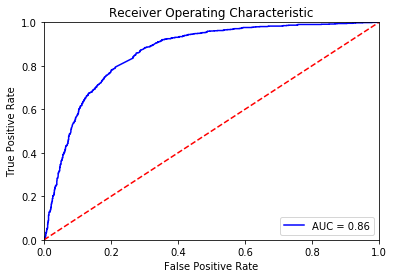

In [24]:
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()